<a href="https://colab.research.google.com/github/Yango4you/FP_TUM/blob/main/Tripletloss(Souvik).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.models import Model
from keras.layers import concatenate,Input
from random import randrange
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10, mnist

1
(60000, 28, 28, 1)


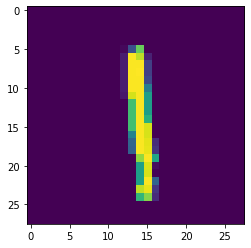

In [46]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
plt.imshow(x_train[8])
print(y_train[8])

x_train = np.expand_dims(x_train,axis=-1)
x_test = np.expand_dims(x_test,axis=-1)
print(x_train.shape)

In [52]:
def get_triplets(labels):
    
    triplets = []
    for label in set(labels):
        label_mask = (labels == label)
        label_indices = np.where(label_mask)[0]
        #print(label_indices)
        if len(label_indices) < 2:
            continue
        negative_indices = np.where(np.logical_not(label_mask))[0]
        anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs

            # Add all negatives for all positive pairs
        temp_triplets = [[anchor_positive[0], anchor_positive[1], neg_ind] for anchor_positive in anchor_positives for neg_ind in negative_indices]
        triplets += temp_triplets
    #print(triplets)
    return triplets

In [48]:
def data_generator(datase, labels, batch_size):
 # Create empty arrays to contain batch of features and labels#
 batch_features_a = np.zeros((batch_size,28, 28,1))
 batch_features_p = np.zeros((batch_size,28, 28,1))
 batch_features_n = np.zeros((batch_size,28, 28,1))
 batch_labels = np.ones((batch_size))
 triplet_list = get_triplets(labels)
 while True:
   for i in range(batch_size):
     # choose random index in features
     index= randrange(len(triplet_list))
     batch_features_a[i] = datase[triplet_list[index][0]]
     batch_features_p[i] = datase[triplet_list[index][1]]
     batch_features_n[i] = datase[triplet_list[index][2]]
     
   yield [batch_features_a,batch_features_p,batch_features_n], batch_labels

In [54]:
def triplet_loss(y_true, y_pred, alpha = 2.0):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """

    anchor = y_pred[0,0:32]
    positive = y_pred[0,32:64]
    negative = y_pred[0,64:96]

    
    print('anchor', anchor.shape)
    print('positive', positive.shape)
    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = 2*pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
 
    return loss

In [50]:
def create_base_network(in_dims, out_dims):
    """
    Base network to be shared.
    """
    model = Sequential()

   

    model.add(SeparableConv2D(32, (3), data_format='channels_last', input_shape=in_dims))

    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.5))

   

    model.add(Conv2D(64, (3)))

    model.add(Activation('relu'))

    model.add(Dropout(0.5))

    model.add(Conv2D(128, (3)))

    model.add(Activation('relu'))

    model.add(Dropout(0.5))

    model.add(MaxPooling2D(pool_size=(2, 2)))

   

    model.add(Conv2D(128, (3)))

    model.add(Activation('relu'))

    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(Activation('relu'))

    

    model.add(Flatten())

    model.add(Dense(out_dims))

    model.add(Activation('linear'))

    return model

In [55]:
in_dims=(28,28,1)
out_dims= 10

anchor_in = Input(shape=in_dims)
pos_in = Input(shape=in_dims)
neg_in = Input(shape=in_dims)

    # Share base network with the 3 inputs
base_network = create_base_network(in_dims, out_dims)
anchor_out = base_network(anchor_in)
pos_out = base_network(pos_in)
neg_out = base_network(neg_in)
merged_vector = concatenate([anchor_out, pos_out, neg_out], axis=-1)

    # Define the trainable model
model = Model(inputs=[anchor_in, pos_in, neg_in], outputs=merged_vector)
model.compile(optimizer=Adam(),
                  loss=triplet_loss,
                  metrics=['accuracy'])

# Training the model
history= model.fit(data_generator(x_train[0:96,:,:,:],y_train[0:96],4), epochs=1)

plt.plot(history.history["loss"])
plt.show()

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7 3 8 6 9 0 5 6
 0 7 6 1 8 7 9 3 9 8 5 9 3 3 0 7 4 9 8 0 9 4 1 4 4 6 0 4 5 6 1 0 0 1 7 1 6
 3 0 2 1 1 7 9 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0]
anchor (30,)
positive (0,)


ValueError: ignored

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(test_acc)